HOMEWORK 04

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


Data preparation

    Check if the missing values are presented in the features.
    If there are missing values:
        For caterogiral features, replace them with 'NA'
        For numerical features, replace with with 0.0
    Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [5]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    lead_score
    number_of_courses_viewed <-- Ans
    interaction_count
    annual_income


In [9]:
for v in numerical:
    score = roc_auc_score(y_train, df_train[v])
    print(f'{v}: {score}')

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.32
    0.52
    0.72
    0.92


In [21]:
dv = DictVectorizer(sparse=False)

In [22]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [23]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 2)

0.82

Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.145
    0.345
    0.545
    0.745 <-- Ans

Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F 1 = 2 ⋅ P ⋅ R P + R

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.14
    0.34
    0.54
    0.74 <-- Ans

/tmp/ipykernel_12186/4145157270.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


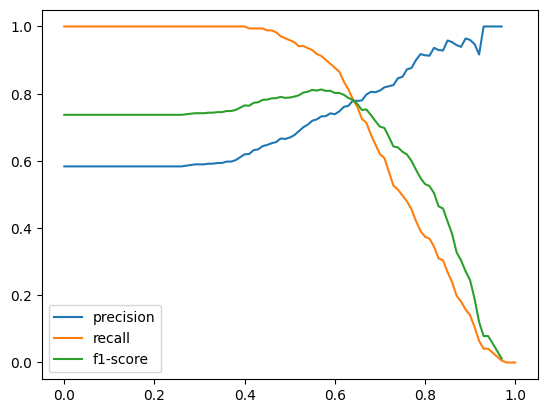

In [44]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * p * r / (p + r)
    scores.append((t, p, r, f1))
scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1-score'])

plt.plot(thresholds, scores['precision'], label='precision')
plt.plot(thresholds, scores['recall'], label='recall')
plt.plot(thresholds, scores['f1-score'], label='f1-score')
plt.legend()


Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

    0.0001
    0.006
    0.06
    0.36


Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.000001, 0.001, 1]
    Initialize KFold with the same parameters as previously
    Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.000001 <-- Ans
    0.001
    1


In [54]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    )
    model.fit(X_train, y_train)

    return dv, model

In [55]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [56]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))

100%|██████████| 3/3 [00:00<00:00, 14.83it/s]

C=1e-06 0.9070 +- 0.0088
C=0.001 0.9111 +- 0.0087
C=1 0.9201 +- 0.0104
